**Importing Files**

In [1]:
import zipfile
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score


**Data Collection and Extraction of data**

Dataset extracted successfully!
Found 507 images.


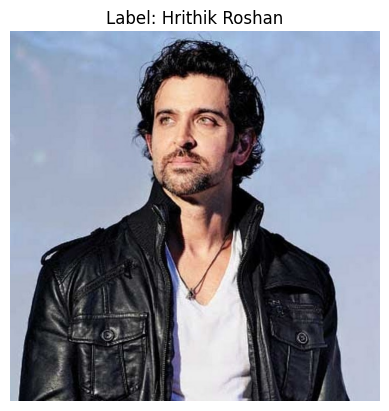

In [2]:
#Step 1: Data Collection & Preprocessing
zip_path = "Faces.zip"
extract_path = "Faces"

# Extract dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully!")

# Load images and labels
image_paths = []
labels = []
for root, _, files in os.walk(extract_path):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(root, file))
            labels.append(os.path.basename(root))

print(f"Found {len(image_paths)} images.")

# Display a sample image with label
sample_idx = np.random.randint(len(image_paths))
sample_image = cv2.imread(image_paths[sample_idx])
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
plt.imshow(sample_image)
plt.title(f"Label: {labels[sample_idx]}")
plt.axis("off")
plt.show()

**Image Preprocessing and Label Encoding**

In [3]:
#Image preprocessing
image_size = (128, 128)
images = []
for image_path in image_paths:
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, image_size)
    images.append(img)
images = np.array(images) / 255.0  # Normalize

# Label encoding
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)
categorical_labels = to_categorical(encoded_labels, num_classes=num_classes)

**CNN Model**

In [4]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    images, categorical_labels, test_size=0.2, random_state=42)

# Step 2: CNN Model (Custom)
def create_custom_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), kernel_regularizer=regularizers.l2(0.001)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

#Step 4: Data Augmentation
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)
datagen.fit(X_train)

# Train & Evaluate CNN Model
custom_cnn = create_custom_cnn()
history_cnn = custom_cnn.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=20, validation_data=(X_test, y_test))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.1116 - loss: 3.4202 - val_accuracy: 0.0882 - val_loss: 2.6789
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.1187 - loss: 2.6796 - val_accuracy: 0.0784 - val_loss: 2.6695
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.1163 - loss: 2.6617 - val_accuracy: 0.0784 - val_loss: 2.6488
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.1292 - loss: 2.6340 - val_accuracy: 0.0686 - val_loss: 2.6194
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.0994 - loss: 2.6093 - val_accuracy: 0.0980 - val_loss: 2.6009
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.0951 - loss: 2.5768 - val_accuracy: 0.1176 - val_loss: 2.5934
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.1654 - loss: 2.5383 - val_accuracy: 0.0686 - val_loss: 2.5636
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.1222 - loss: 2.5214 - val_accuracy: 0.1569 - val_loss:

**Transfer Learning with ResNet50**

In [5]:
# Step 3: Transfer Learning with ResNet50
def create_resnet_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

    # Unfreeze some layers for better fine-tuning
    for layer in base_model.layers[:140]:
        layer.trainable = False
    for layer in base_model.layers[140:]:
        layer.trainable = True

#Train & Evaluate ResNet Model
resnet_model = create_resnet_model()
history_resnet = resnet_model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=10, validation_data=(X_test, y_test))



Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.0749 - loss: 2.4673 - val_accuracy: 0.0588 - val_loss: 2.3322
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.1062 - loss: 2.3052 - val_accuracy: 0.0980 - val_loss: 2.3573
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.1210 - loss: 2.3066 - val_accuracy: 0.0686 - val_loss: 2.3427
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.1462 - loss: 2.2921 - val_accuracy: 0.0784 - val_loss: 2.3401
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.1433 - loss: 2.2934 - val_accuracy: 0.0588 - val_loss: 2.3323
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.1474 - loss: 2.2868 - val_accuracy: 0.0980 - val_loss: 2.3276
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.1682 - loss: 2.2866 - val_accuracy: 0.0980 - val_loss: 2.3237
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.1418 - loss: 2.2841 - val_accuracy: 0.1471 - val_loss:

**Model Evaluation**

In [6]:
# Step 5: Model Evaluation
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

print("Custom CNN Evaluation:")
evaluate_model(custom_cnn, X_test, y_test)

print("ResNet50 Transfer Learning Evaluation:")
evaluate_model(resnet_model, X_test, y_test)

# Step 6: Save Models
custom_cnn.save("custom_cnn_model.h5")
resnet_model.save("resnet_face_model.h5")

print("Models saved successfully!")

Custom CNN Evaluation:
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.1471, Precision: 0.2380, Recall: 0.1471
ResNet50 Transfer Learning Evaluation:
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.0784, Precision: 0.0666, Recall: 0.0784
Models saved successfully!
